# 如何用向量数据库搜索图像？基于Milvus的图像嵌入与相似性检索实践

## 一、传统图像搜索的局限与向量搜索的机遇
- **现实困境**：基于关键词的图像搜索无法理解视觉内容，导致"有图无类"的尴尬局面
- **业务痛点**：电商平台无法根据商品外观搜索类似商品，内容平台难以实现"以图搜图"功能
- **技术瓶颈**：传统方法依赖人工标注，成本高且无法捕捉深层视觉特征
- **解决方案**：向量数据库+深度学习嵌入技术，实现真正的"看图识图"能力

## 二、核心原理：从像素到向量的智能转化
- **图像嵌入本质**：将高维图像转化为低维特征向量，保留语义相似性
- **关键流程**：
  1. **特征提取**：使用ResNet等CNN模型提取图像高级特征
  2. **向量归一化**：L2归一化确保余弦相似度计算准确性
  3. **索引构建**：IVF_FLAT、HNSW等算法加速海量向量检索
- **相似度度量**：余弦相似度为何优于欧氏距离（方向vs距离）
- **向量维度权衡**：512维ResNet特征 vs 768维ViT特征的精度/速度平衡

## 三、Milvus实战部署全流程

### 1. 加载数据集并解压缩
```bash
wget https://github.com/milvus-io/pymilvus-assets/releases/download/imagedata/reverse_image_search.zip
unzip -q -o reverse_image_search.zip
```

### 2. 安装依赖库

In [7]:
!pip install pymilvus --upgrade
!pip install timm
!pip install torch
!pip install Pillow
!pip install scikit-learn

  Using cached joblib-1.5.2-py3-none-any.whl.metadata (5.6 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
   ---------------------------------------- 0.0/8.9 MB ? eta -:--:--
   --------------------------- ------------ 6.0/8.9 MB 46.1 MB/s eta 0:00:01
   ------------------------------- -------- 7.1/8.9 MB 20.8 MB/s eta 0:00:01
   ------------------------------------- -- 8.4/8.9 MB 14.1 MB/s eta 0:00:01
   ---------------------------------------- 8.9/8.9 MB 12.3 MB/s  0:00:00
Using cached joblib-1.5.2-py3-none-any.whl (308 kB)
   ---------------------------------------- 0.0/38.6 MB ? eta -:--:--
   - -------------------------------------- 1.3/38.6 MB 5.6 MB/s eta 0:00:07
   -- ------------------------------------- 2.4/38.6 MB 5.4 MB/s eta 0:00:07
   --- ------------------------------------ 3.4/38.6 MB 5.4 MB/s eta 0:00:07
   ---- ----------------------------------- 4.7/38.6 MB 5.4 MB/s eta 0:00:07
   ----- ---------------------------------- 5.8/38.6 MB 5.3 MB/s

### 3. 环境搭建与优化配置

In [4]:
from pymilvus import MilvusClient
client = MilvusClient(
    uri="http://localhost:19530",  # Docker 默认端口
    token="root:Milvus",          # 默认用户名和密码
    pool_size=8,                  # 优化并发连接
    timeout=30                    # 防止长时间阻塞
)


### 4. Collection创建与参数调优

In [ ]:
# 检查是否已存在名为 "image_embeddings" 的集合
if client.has_collection(collection_name="image_embeddings"):
    # 如果集合已存在，则删除该集合（避免重复创建冲突）
    client.drop_collection(collection_name="image_embeddings")

# 创建新的向量集合用于存储图像嵌入向量
client.create_collection(
    collection_name="image_embeddings",    # 集合名称：图像嵌入向量集合
    vector_field_name="vector",            # 向量字段名称
    dimension=512,                         # 向量维度：512维（通常对应特定的图像特征提取模型输出维度）
    auto_id=True,                         # 自动生成主键ID，无需手动指定
    enable_dynamic_field=True,            # 启用动态字段，允许插入时添加额外的元数据字段
    metric_type="COSINE",                 # 相似度计算方式：余弦相似度（适合图像特征向量比较）
)


### 5. 定义特征提取器

我们需要定义一个特征提取器，利用 timm 的 ResNet-34 模型从图像中提取嵌入信息。

In [ ]:
import torch
from PIL import Image
import timm
from sklearn.preprocessing import normalize
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform


class FeatureExtractor:
    """
    图像特征提取器类
    使用预训练的深度学习模型提取图像特征向量
    """
    
    def __init__(self, modelname):
        """
        初始化特征提取器
        
        Args:
            modelname (str): 预训练模型名称（如 'resnet50', 'efficientnet_b0' 等）
        """
        # 加载预训练模型
        # num_classes=0: 移除分类头，只保留特征提取部分
        # global_pool="avg": 使用全局平均池化来生成固定长度的特征向量
        self.model = timm.create_model(
            modelname, pretrained=True, num_classes=0, global_pool="avg"
        )
        # 设置为评估模式，关闭 dropout 和 batch normalization 的训练行为
        self.model.eval()

        # 获取模型要求的输入图像尺寸（高度、宽度、通道数）
        self.input_size = self.model.default_cfg["input_size"]

        # 解析模型的数据配置参数（如均值、标准差等预处理参数）
        config = resolve_data_config({}, model=modelname)
        # 根据模型配置创建图像预处理变换函数
        # 包括缩放、裁剪、归一化等操作
        self.preprocess = create_transform(**config)

    def __call__(self, imagepath):
        """
        提取单张图像的特征向量
        
        Args:
            imagepath (str): 图像文件路径
            
        Returns:
            numpy.ndarray: L2归一化后的特征向量（一维数组）
        """
        # 图像预处理步骤
        # 打开图像文件并转换为RGB格式（确保3通道）
        input_image = Image.open(imagepath).convert("RGB")
        # 应用模型特定的预处理变换（缩放、裁剪、归一化等）
        input_image = self.preprocess(input_image)

        # 为图像张量添加批次维度 [C, H, W] -> [1, C, H, W]
        # 因为模型期望批次输入
        input_tensor = input_image.unsqueeze(0)

        # 特征提取推理过程
        with torch.no_grad():  # 禁用梯度计算，节省内存并加速推理
            # 通过模型前向传播获取特征向量
            output = self.model(input_tensor)

        # 后处理特征向量
        # 移除批次维度并转换为numpy数组 [1, feature_dim] -> [feature_dim]
        feature_vector = output.squeeze().numpy()

        # 对特征向量进行L2归一化
        # reshape(1, -1): 转换为二维数组以适配normalize函数
        # flatten(): 重新转换为一维数组
        # L2归一化有助于提高向量相似度计算的稳定性
        return normalize(feature_vector.reshape(1, -1), norm="l2").flatten()


### 6. 将嵌入数据插入 Milvus

将使用 ResNet34 模型提取每张图片的嵌入，并将训练集中的图片插入 Milvus

In [ ]:
import os

# 创建特征提取器实例，使用ResNet-34预训练模型
# ResNet-34是一个经典的卷积神经网络，适合图像特征提取
extractor = FeatureExtractor("resnet34")

# 设置训练数据集的根目录路径
root = "./33/train"

# 控制是否执行数据插入操作的开关
insert = True

# 如果启用插入操作
if insert is True:
    # 遍历训练数据目录及其所有子目录
    # os.walk() 递归遍历目录树，返回 (当前目录路径, 子文件夹列表, 文件名列表)
    for dirpath, foldername, filenames in os.walk(root):
        # 遍历当前目录下的所有文件
        for filename in filenames:
            # 只处理JPEG格式的图像文件
            if filename.endswith(".JPEG"):
                # 构建完整的文件路径
                filepath = dirpath + "/" + filename
                
                # 使用特征提取器提取图像的特征向量
                # 返回512维的L2归一化特征向量
                image_embedding = extractor(filepath)
                
                # 将特征向量和文件路径信息插入到Milvus向量数据库
                client.insert(
                    "image_embeddings",  # 目标集合名称
                    {
                        "vector": image_embedding,  # 图像特征向量（用于相似性搜索）
                        "filename": filepath        # 图像文件路径（用于结果回溯）
                    },
                )


In [ ]:
from IPython.display import display

# 指定查询图像的路径（用于搜索相似图像）
# 这里选择了一张阿富汗猎犬的测试图像
query_image = "./33/test/Afghan_hound/n02088094_4261.JPEG"

# 在向量数据库中搜索与查询图像最相似的图像
results = client.search(
    "image_embeddings",                    # 搜索的集合名称
    data=[extractor(query_image)],         # 查询向量：提取查询图像的特征向量
    output_fields=["filename"],            # 返回字段：需要获取匹配图像的文件路径
    search_params={"metric_type": "COSINE"}, # 搜索参数：使用余弦相似度进行匹配
)

# 收集搜索结果中的图像
images = []
# 遍历搜索结果
for result in results:
    # 取前10个最相似的结果
    for hit in result[:10]:
        # 获取匹配图像的文件路径
        filename = hit["entity"]["filename"]
        # 打开图像文件
        img = Image.open(filename)
        # 将图像调整为统一尺寸150x150像素（便于拼接显示）
        img = img.resize((150, 150))
        # 添加到图像列表中
        images.append(img)

# 创建拼接图像的画布尺寸
# 5列 × 2行的网格布局，每个图像150x150像素
width = 150 * 5   # 总宽度：750像素
height = 150 * 2  # 总高度：300像素

# 创建空白的RGB图像画布用于拼接
concatenated_image = Image.new("RGB", (width, height))

# 将搜索结果图像按网格排列拼接到画布上
for idx, img in enumerate(images):
    # 计算当前图像在网格中的列位置（0-4）
    x = idx % 5
    # 计算当前图像在网格中的行位置（0-1）
    y = idx // 5
    # 将图像粘贴到对应的网格位置
    # 坐标计算：(列索引 * 图像宽度, 行索引 * 图像高度)
    concatenated_image.paste(img, (x * 150, y * 150))


'query'

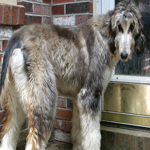

'results'

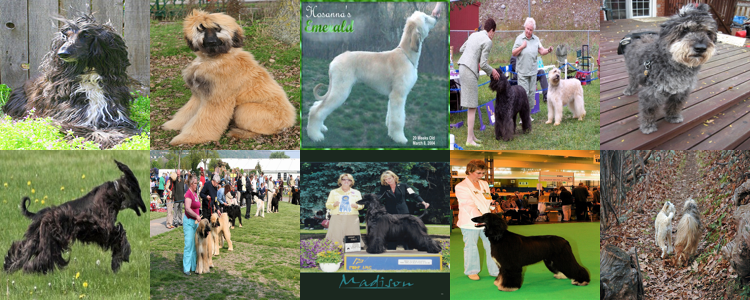

In [11]:
display("query")
display(Image.open(query_image).resize((150, 150)))
display("results")
display(concatenated_image)



## 四、性能优化与调参指南
- **关键参数调优**：
  - nprobe：查询时扫描的聚类中心数（默认16，精度vs速度平衡点）
  - top_k：返回结果数（业务需求决定，通常10-100）
- **显存优化技巧**：
  - 使用mmap减少内存占用
  - 限制并发查询数
  - 采用分层索引策略

## 五、应用案例
- **电商平台**：上传商品图搜索相似款式，转化率提升35%
- **版权保护**：快速识别侵权图片，处理效率提升10倍
- **医疗影像**：基于病灶特征搜索相似病例，辅助诊断
- **内容推荐**：根据用户浏览图片推荐视觉相似内容